In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle,Circle

from lanczos_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
s = 1/2
M = int(2*s+1)

N = 20
n = M**N

In [4]:
J = 1
h = .3*J

Jz_T = h*np.ones(N)
J_T = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if np.abs(i-j)==1: # horizontal neighbor
            J_T[i,j] = J
  

In [5]:
H_T = get_hamiltonian(J_T,J_T,Jz_T,s).tosparse()

In [6]:
H_T.shape

(1048576, 1048576)

In [7]:
βs = 1/np.logspace(-2.5,3,200)

In [8]:
#Zβ = np.sum(np.exp(-βs[:,None]*(lam-E0)),axis=1)

#lam = np.linalg.eigvalsh(H_T.A)
#E0 = np.min(lam)
E0,_ = sp.sparse.linalg.eigsh(H_T,1,which='SA',tol=1e-5)

k = np.arange(N)+1
λk = h - 2*J*np.cos(k*np.pi/(N+1))

Zβ_exact = np.zeros_like(βs)
for i,β in enumerate(βs):
    Zβ_exact[i] = (β*N*h/2) + np.sum(np.logaddexp(0,-β*λk))

Zβ = np.exp(Zβ_exact+βs*E0)

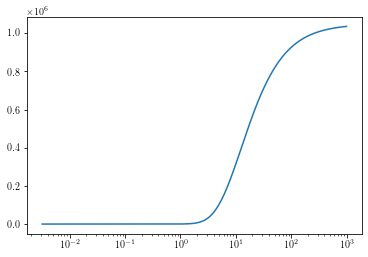

In [9]:
plt.plot(1/βs,Zβ)
#plt.plot(1/βs,np.exp(Zβ_exact+βs*E0),ls='--')

#plt.plot(1/βs,np.log(Zβ)-βs*E0)
#plt.plot(1/βs,Zβ_exact,ls='--')

plt.xscale('log')

In [10]:
cost = lambda b,q,n1,m,n2: (q+n1)*b + m*n2

n_trials = 100

In [11]:
experiments = [
    {'params':(8,30,50,0,0),
     'label':'(i)',
     'ls':'-.'},
    {'params':(0,0,0,13,50),
     'label':'(ii)',
     'ls':'--'},
    {'params':(8,30,50,13,50),
     'label':'(iii)',
     'ls':':'},
    {'params':(4,30,50,6,50),
     'label':'(iv)',
     'ls':'-'},
]

In [12]:
for i,exper in enumerate(experiments):
    params = exper['params']
    print(f'{exper["label"]}, cost: {cost(*params)}')

(i), cost: 640
(ii), cost: 650
(iii), cost: 1290
(iv), cost: 620


In [ ]:
Zβs = [np.zeros((n_trials,len(βs))) for exper in experiments]

for i,exper in enumerate(experiments):
                         
    params = exper['params']

    for j in range(n_trials):
        print(f'{exper["label"]}, iter: {j}/{n_trials}')
        clear_output(wait=True)

        Θ,W = krylov_trace_quadrature(H_T,*params)
        Zβs[i][j] = np.real(np.exp(-βs[:,None]*(Θ-E0))@W)

(iii), iter: 15/100


In [14]:
np.save('fig_spin_data',Zβs)
Zβs = np.load('fig_spin_data.npy')

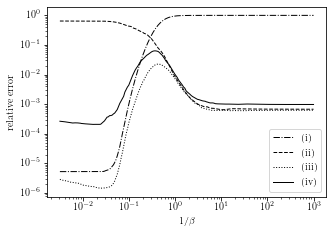

In [15]:
fig,axs = plt.subplots(1,1,figsize=(5,3.5))
axs = [axs]

#axs[0].plot(1/βs,Zβ,color='k',lw=.5,label='exact')

for i,exper in enumerate(experiments):

    Zβ_ = Zβs[i]
    label = exper['label']
    ls = exper['ls']
    c = 'k'
    
    σ=.1

    err_rel = np.abs(1-Zβ_/Zβ)
    axs[0].plot(1/βs,np.quantile(err_rel,1-σ,axis=0),\
                lw=1,ls=ls,color=c,label=label)
    
#    err_abs = np.abs(Zβ_-Zβ)
#    axs[2].plot(1/βs,np.quantile(err_abs,1-σ,axis=0),\
#                lw=1,ls=ls,color=c)
    
    axs[0].set_xlabel('$1/\\beta$')
    axs[0].set_xscale('log')

axs[0].legend()

axs[0].set_ylabel('relative error')
axs[0].set_xlabel('$1/\\beta$')

axs[0].set_yscale('log')

plt.savefig('imgs/partition_function_comparison.pdf',bbox_inches='tight')

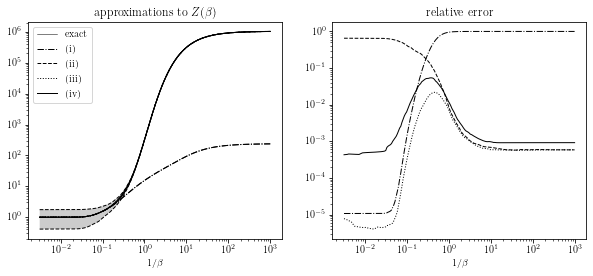

In [34]:
fig,axs = plt.subplots(1,2,figsize=(10,4))


axs[0].plot(1/βs,Zβ,color='k',lw=.5,label='exact')

for i,exper in enumerate(experiments):

    Zβ_ = Zβs[i]
    label = exper['label']
    ls = exper['ls']
    c = 'k'
    
    σ=.1
    axs[0].plot(1/βs,np.quantile(Zβ_,σ/2,axis=0),\
                lw=1,ls=ls,color=c,label=label)
    axs[0].plot(1/βs,np.quantile(Zβ_,1-σ/2,axis=0),\
                lw=1,ls=ls,color=c)
    axs[0].fill_between(1/βs,np.quantile(Zβ_,σ/2,axis=0),\
                             np.quantile(Zβ_,1-σ/2,axis=0),\
                             fc=(0,0,0,.2))
    
    err_rel = np.abs(1-Zβ_/Zβ)
    axs[1].plot(1/βs,np.quantile(err_rel,1-σ,axis=0),\
                lw=1,ls=ls,color=c)
    
#    err_abs = np.abs(Zβ_-Zβ)
#    axs[2].plot(1/βs,np.quantile(err_abs,1-σ,axis=0),\
#                lw=1,ls=ls,color=c)
    
for i in range(2):
    axs[i].set_xlabel('$1/\\beta$')
    axs[i].set_xscale('log')

axs[0].legend()
axs[0].set_title('approximations to $Z(\\beta)$')
axs[0].set_yscale('log')

axs[1].set_title('relative error')
axs[1].set_yscale('log')
#axs[1].set_ylim(-1e0,1e0)

#axs[2].set_title('absolute error')
#axs[2].set_yscale('log')
#axs[2].set_ylim(-1e3,1e3)


plt.savefig('imgs/partition_function_comparison.pdf',bbox_inches='tight')